In [3]:
# Imports
from scipy.integrate import odeint
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

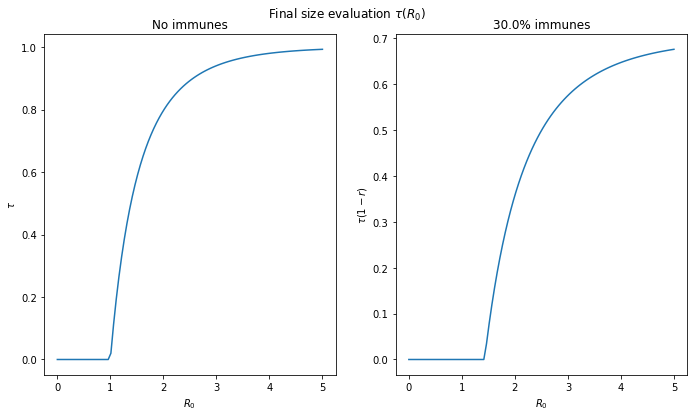

In [4]:
# Exercise 1
num_points = 100
r0s = np.linspace(0, 5, num_points)

def final_size_func(tau, r0, immune):
    """
    Equation for final_size. Solution is found when the expression is equal to 0.
    :param tau: Variable of interest, \tau(r0, immune) is the final size fraction.
    :param r0: Basic reproduction number r0.
    :param immune: Fraction of population that is immune to disease.
    :return: Function to be solved for zero.
    """
    return 1 - tau - np.exp(-r0*(1-immune)*tau)

taus = np.zeros(num_points)
taus_with_immunes = np.zeros(num_points)

# Solve for tau when no-one is immune. a)
for i, r0 in enumerate(r0s):
    taus[i] = opt.fsolve(final_size_func, 0.5, args=(r0, 0))

frac_immune = 0.3

# Solve for tau when 30 % is immune. b)
for i, r0 in enumerate(r0s):
    taus_with_immunes[i] = opt.fsolve(final_size_func, 0.5, args=(r0, frac_immune)) * (1-frac_immune)
    

# Plot the result for a) and b)
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle(r'Final size evaluation $\tau(R_0)$')
axs[0].set_title('No immunes')
axs[0].set_ylabel(r'$\tau$')
axs[0].set_xlabel(r'$R_0$')
axs[0].plot(r0s, taus)
             
axs[1].set_title(f'{frac_immune*100}% immunes')
axs[1].set_ylabel(r'$\tau(1-r)$')
axs[1].set_xlabel(r'$R_0$')
axs[1].plot(r0s, taus_with_immunes)

plt.tight_layout(pad=2)
plt.show()

In [5]:
class StaticSEIR:
    
    """
    SEIR class for modelling diseases. This class assumes non-varying parameters. Used for Exercise 2a)->2b)
    
    Model (Exercise 2a): 
    dS/dt = -beta * S* I
    dE/dt = beta * S* I - rho*E
    dI/dt = rho*E - gam * I
    dR/dt = gam * I
    """

    def __init__(self, init_values=np.array([99, 0, 1, 0])):
        """
        Initialization methos, holds initial values and total number in population.
        :(Optional) param init_values: Array of starting values: [Susceptible, Exposed, Infected, Recovered] = [s0, e0, i0, r0]
        """
        
        self.init_values = np.array(init_values) 
        self.N = sum(init_values)
    
    def model(self, curr_state, params):
        """
        Model function which returns derivatives at current point.
        :param curr_state: Current model state, ex: [Susceptible, Exposed, Infected, Recovered] = [100, 20, 10, 50]
        :param params: Model parameters (beta, rho, gam).
        :return: Array of derivatives at current point.
        """
        S, E, I, R = curr_state

        beta, rho, gam = params
        dSdt = -beta * S* I
        dEdt = beta * S* I - rho*E
            
        dIdt = rho*E - gam * I
        dRdt = gam * I
        
        return np.array([dSdt, dEdt, dIdt, dRdt])
    
    def solve(self, params, days=100, step_size=0.01):
        """
        Solves the initial value problem using the euler-method updating scheme.
        :param params: Model parameters (beta, rho, gam).
        :(Optional) param days: Number of days for simulation. (Default=100)
        :(Optional) param step_size: Step_size for euler-method. (Default=0.01)
        :return: Pandas dataframe of the simulation.
        """
        steps = math.ceil(days/step_size) + 1
        t = np.linspace(0, days, steps)
        seir = np.zeros((steps, 4))
        seir[0] = self.init_values
        
        for step in range(1, steps):
            prev = seir[step-1]
            seir[step] = prev + step_size * self.model(prev, params)
        
        return pd.DataFrame(seir, index=t, columns=['S', 'E', 'I', 'R'])

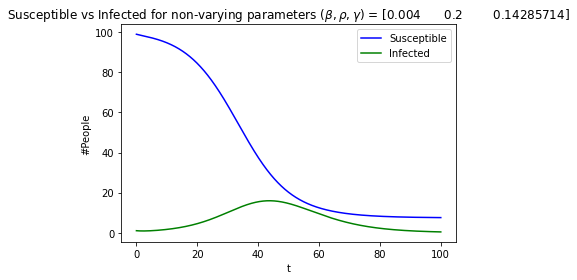

In [98]:
#Exercise 2b)
params1 = np.array([0.004, 1/5, 1/7])
sseir = StaticSEIR()

ssol = sseir.solve(params=params1)

fig, ax = plt.subplots()
ax.plot(ssol.index, ssol['S'], 'b')
ax.plot(ssol.index, ssol['I'], 'g')
ax.legend(['Susceptible', 'Infected'])
ax.set_title(r'Susceptible vs Infected for non-varying parameters $(\beta, \rho, \gamma)$ = {}'.format(params1))
ax.set_xlabel('t')
ax.set_ylabel('#People')
plt.show()

In [87]:
class VaryingSEIR:
    
    """
    SEIR class for modelling diseases. This class assumes varying parameter beta i.e beta = beta(t, *args). Used for Exercise 2c)->3a)
    
    Model (Exercise 2a): 
    dS/dt = -beta * S* I
    dE/dt = beta * S* I - rho*E
    dI/dt = rho*E - gam * I
    dR/dt = gam * I
    """
    
    def __init__(self, init_values=np.array([99, 0, 1, 0])):
        """
        Initialization methos, holds initial values and total number in population.
        :(Optional) param init_values: Array of starting values: [Susceptible, Exposed, Infected, Recovered] = [s0, e0, i0, r0]
        """
        self.init_values = np.array(init_values) 
        self.N = sum(init_values)
        
    def get_beta(self, t, beta0, beta1, t1, w):
        """
        Function for extraction parameter beta since beta now depends on time.
               { beta0 if t <= t1 - w.
        beta = { beta1 if t > t1 + w.
               { beta0 + (t - t1 + w) * (beta1 - beta0) / (2 * w) else.
               
        :param t: Independent variable t for function beta(t, *args).
        :param beta0: Parameter beta0 for function beta(t, *args) in accordance with the formula above. 
        :param beta1: Parameter beta1 for function beta(t, *args) in accordance with the formula above. 
        :param t1: Parameter t1 for function beta(t, *args) in accordance with the formula above. 
        :param w: Parameter w for function beta(t, *args) in accordance with the formula above. 
        """
        if t <= t1-w:
            beta = beta0
        elif t > t1+w:
            beta = beta1
        else:
            beta = beta0 + (t-t1+w)*(beta1-beta0)/(2*w)

        return beta
    
    def model(self, curr_state, t, params):
        """
        Model function which returns derivatives at current point.
        :param curr_state: Current model state, ex: [Susceptible, Exposed, Infected, Recovered] = [100, 20, 10, 50]
        :param t: Current time t.
        :param params: Model parameters (beta0, beta1, t1, w, rho, gam).
        :return: dSdt - Derivative of S at current state. 
                 dEdt - Derivative of E at current state. 
                 dIdt - Derivative of I at current state. 
                 dRdt - Derivative of R at current state. 
        """
        S, E, I, R = curr_state
        beta0, beta1, t1, w, rho, gam = params
        beta = self.get_beta(t, beta0, beta1, t1, w)
        
        dSdt = -beta * S* I
        dEdt = beta * S* I - rho*E
        dIdt = rho*E - gam * I
        dRdt = gam * I
        
        return dSdt, dEdt, dIdt, dRdt
    
    def solve(self, params, days=100, step_size=0.01):
        """
        Solves the initial value problem using the optimization routine odeint.
        :param params: Model parameters (beta0, beta1, t1, w, rho, gam).
        :(Optional) param days: Number of days for simulation. (Default=100)
        :(Optional) param step_size: Step_size. (Default=0.01)
        :return: Pandas dataframe of the simulation.
        """
        steps = math.ceil(days/step_size) + 1
        t = np.linspace(0, days, steps)

        seir = odeint(self.model, self.init_values, t, args=(params, ))
        return pd.DataFrame(seir, index=t, columns=['S', 'E', 'I', 'R'])
    
    def _lsq_infected_daily(self, params, data, rho):
        """
        Helper function which calulates square root of RSS. (Minimized to fit parameters).
        :param params: Model parameters to be optimized (beta0, beta1, t1, w, gam).
        :param rho: Model parameter that shall not be changed.
        """
        params = np.hstack((params[:4], rho, params[-1]))
        sol = self.solve(np.exp(params), days=len(data) - 1, step_size=1)
        return np.linalg.norm(data - sol['I'])
    
    def fit_infected_daily(self, data, guess_params, rho=1/5):
        """
        Fits parameter of model to observed infected data by minimizing least square function.
        :param data: Observed data.
        :param guess_params: Guess of optimal parameters.
        :param rho: parameter rho (shall not be changed).
        :return: Optimal parameters (NB! Sensitive to guessed parameters.)
        """
        mle = opt.minimize(self._lsq_infected_daily, np.log(guess_params), args=(data, np.log(rho)))
        return mle.x

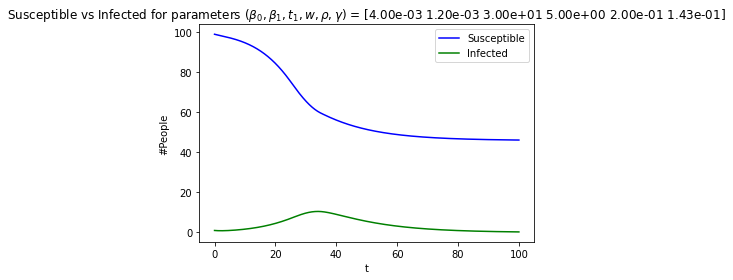

In [104]:
# Exercise 2d)
params2 = np.array([0.004, 0.0012, 30, 5, 1/5, 1/7])
vseir = VaryingSEIR()
vsol = vseir.solve(params2)

fig, ax = plt.subplots()
ax.plot(vsol.index, vsol['S'], 'b')
ax.plot(vsol.index, vsol['I'], 'g')
ax.legend(['Susceptible', 'Infected'])
np.set_printoptions(2)
ax.set_title(r'Susceptible vs Infected for parameters $(\beta_0, \beta_1, t_1, w, \rho, \gamma)$ = {}'.format(params2))
ax.set_xlabel('t')
ax.set_ylabel('#People')
plt.show()

In [56]:
# Exercise 3a) read data
with open('Data_2020-04-10Ny.txt', 'r') as f:
    dates, infected = [], []
    lines = f.readlines()
    for line in lines[1:]:
        date, _infected = line.split()
        dates.append(date)
        infected.append(int(_infected))

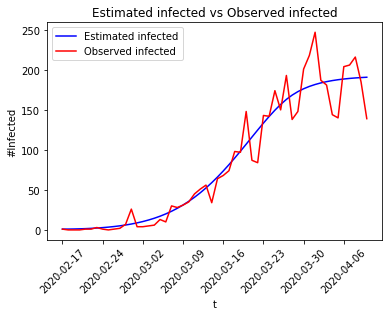

Optimal parameters: [3.31e-07 7.45e-12 5.74e+00 3.37e+01 2.00e-01 1.15e-06]


In [111]:
# Exercise 3a) fit parameters
guess_fit = np.array([0.00000007, 0.00000008, 30, 5, 1/7])
N = 2.37455e6

vseir = VaryingSEIR(init_values=np.array([N, 0, 1, 0]))

# Actual fitting
opt_params = np.exp(vseir.fit_infected_daily(infected, guess_params=guess_fit))

# Insert rho.
opt_params = np.hstack((opt_params[:4], 1/5, opt_params[-1]))

# Solve the system with opt parameters.
vsol = vseir.solve(opt_params, days=len(dates) - 1, step_size=1)

# Plot the result
fig, ax = plt.subplots()
ax.plot(dates, vsol['I'], 'b')
ax.plot(dates, infected, 'r')

_ticks = dates[::7]
ax.set_xticks(_ticks)
plt.xticks(rotation=45)

ax.legend(['Estimated infected', 'Observed infected'])

ax.set_title('Estimated infected vs Observed infected')
ax.set_xlabel('t')
ax.set_ylabel('#Infected')
plt.show()
print('Optimal parameters:', opt_params)

In [112]:
# Exercise 4a) read from file and find total number of deaths during period.
rep_triangle = pd.read_csv('rT-covid19-deaths-sweden (1).csv')
print(rep_triangle)
total_deaths = int(np.nansum(rep_triangle.loc[:, rep_triangle.columns != 'date'].to_numpy()))
print('Total deaths:', total_deaths)

          date   0     1     2     3     4    5    6    7    8  ...   79   80  \
0   2020-04-02   5  17.0  14.0   7.0   4.0  8.0  4.0  6.0  2.0  ...  0.0  0.0   
1   2020-04-03   2  16.0   4.0  12.0  15.0  5.0  4.0  6.0  1.0  ...  0.0  1.0   
2   2020-04-04   1   5.0  11.0  23.0   8.0  6.0  3.0  0.0  0.0  ...  0.0  0.0   
3   2020-04-05   1  22.0  26.0   9.0   9.0  8.0  0.0  0.0  0.0  ...  0.0  0.0   
4   2020-04-06  13  24.0  18.0  11.0   8.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
..         ...  ..   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...  ...   
84  2020-06-25   0   4.0   0.0   0.0   2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
85  2020-06-26   0   0.0   0.0   2.0   NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
86  2020-06-27   0   0.0   1.0   NaN   NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
87  2020-06-28   0   4.0   NaN   NaN   NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
88  2020-06-29   0   NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

     81   82   83   84   85

In [18]:
# Exercise 4b) part 1, find deaths per day.
_daily_deaths = np.nansum(rep_triangle.loc[:, rep_triangle.columns != 'date'].to_numpy(), axis=1)
_daily_deaths = pd.DataFrame(_daily_deaths.astype(int), columns=['deaths'])

deaths_per_day = pd.concat([rep_triangle['date'], _daily_deaths], axis=1)
print(deaths_per_day)

          date  deaths
0   2020-04-02      73
1   2020-04-03      83
2   2020-04-04      73
3   2020-04-05      87
4   2020-04-06      95
..         ...     ...
84  2020-06-25       6
85  2020-06-26       2
86  2020-06-27       1
87  2020-06-28       4
88  2020-06-29       0

[89 rows x 2 columns]


In [19]:
def ma(signal, window_length):
    """
    Calculates moving average by convolving incoming signal with normalized uniform window.
    :param signal: Incoming signal.
    :param window_length: Length of normalized uniform window.
    :return: Ma(window_length) process of the signal.
    """
    window = np.ones(window_length) / window_length
    return np.convolve(signal, window)[window_length-1:]

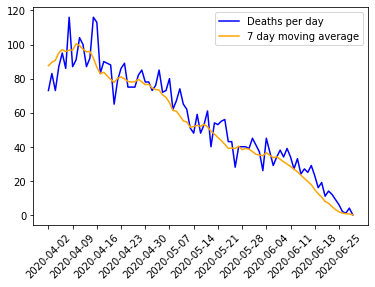

In [20]:
# Plot Deaths per day with the moving average.
fig, ax = plt.subplots()
ax.plot(deaths_per_day['date'], deaths_per_day['deaths'], 'b')
ax.plot(deaths_per_day['date'], ma(deaths_per_day['deaths'], 7), 'orange')
date_ticks = deaths_per_day.loc[::7, 'date']
ax.set_xticks(date_ticks)
ax.legend(['Deaths per day', '7 day moving average'])
plt.xticks(rotation=45)
plt.show()

In [21]:
# Exercise 4c) part 1, Modify dataframe such that all cases > 20 are placed in 20 bin. 
max_delay = 20
_rep_tri = rep_triangle.loc[:, rep_triangle.columns != 'date'].to_numpy()
_delay_geq_20_sum = np.nansum(_rep_tri[:, max_delay:], axis=1)
rows, cols = _rep_tri.shape
_delay_geq_20_sum[cols - max_delay + 1:] = np.nan 

_labels_to_drop = list(map(str, range(max_delay + 1, cols)))

modified_rep_triangle = rep_triangle.drop(columns=_labels_to_drop)
modified_rep_triangle[str(max_delay)] = _delay_geq_20_sum
print(modified_rep_triangle)

          date   0     1     2     3     4    5    6    7    8  ...   11   12  \
0   2020-04-02   5  17.0  14.0   7.0   4.0  8.0  4.0  6.0  2.0  ...  0.0  2.0   
1   2020-04-03   2  16.0   4.0  12.0  15.0  5.0  4.0  6.0  1.0  ...  3.0  1.0   
2   2020-04-04   1   5.0  11.0  23.0   8.0  6.0  3.0  0.0  0.0  ...  1.0  1.0   
3   2020-04-05   1  22.0  26.0   9.0   9.0  8.0  0.0  0.0  0.0  ...  1.0  0.0   
4   2020-04-06  13  24.0  18.0  11.0   8.0  0.0  0.0  0.0  0.0  ...  2.0  1.0   
..         ...  ..   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...  ...   
84  2020-06-25   0   4.0   0.0   0.0   2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
85  2020-06-26   0   0.0   0.0   2.0   NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
86  2020-06-27   0   0.0   1.0   NaN   NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
87  2020-06-28   0   4.0   NaN   NaN   NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
88  2020-06-29   0   NaN   NaN   NaN   NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

     13   14   15   16   17